In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from utils import *
from models.models import *
from data.cifar import cifar_dataloaders
from data.body_temp import get_temp_data
from data.atmospheric_temp import preprocess_data, atmospheric_dataloaders
from data.financial_data import preprocess_financial_data, financial_dataloaders
from time import sleep
import torch.optim as optim
from tqdm import tqdm
import time
import math

In [2]:
ensure_reproducibility(42)

<h2> CIFAR-10 with ResNet18

In [3]:
activations_dict = {'tanh': nn.Tanh(), 'Leaky ReLU': nn.LeakyReLU(), 
                    'sin': SinActivation(), 'swish': nn.SiLU(), 
                    'ReLU': nn.ReLU(), 'snake, a = 0.5': SnakeActivation(0.5)}

Configuration for training ResNet18 on CIFAR

In [4]:
BATCH_SIZE = 32
EPOCHS = 50

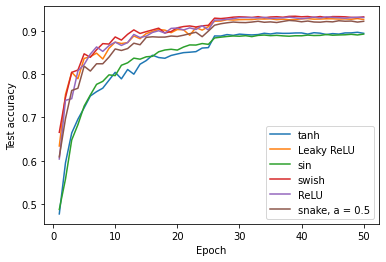

In [11]:
train_dl, test_dl = cifar_dataloaders(batch_size=BATCH_SIZE)
for act_name, act_func in activations_dict.items():
    model = ResNet18WithActivation(act_func)
    print(f"Training ResNet18 on CIFAR with activation {act_name}")
    model, test_accuracies = train_cifar(model, train_dl, test_dl, epochs=EPOCHS, verbose=False)
    plt.plot(range(1, EPOCHS+1), test_accuracies, label=act_name)

plt.xlabel("Epoch")
plt.ylabel("Test accuracy")
plt.legend()

<h2> Atmospheric temperature regression

In [3]:
NUM_RUNS = 21
EPOCHS = 1000
ARCHITECTURE = (1, 100, 100, 1)

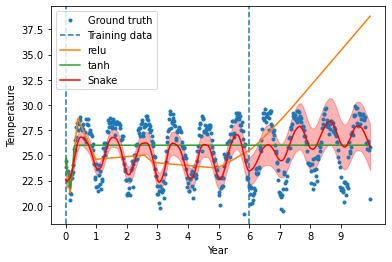

In [4]:
y = torch.Tensor(preprocess_data("data/10_year_temp_data.json")).reshape(-1, 1)
X = torch.Tensor(range(len(y))).reshape(-1, 1)

train_dl, test_dl = atmospheric_dataloaders()

preds = []
train_loss_runs = []
test_loss_runs = []


plt.plot(X, y, '.', label="Ground truth")
plt.xticks(range(0, 52*10, 52), range(0, 10, 1))
plt.axvline(x=0, linestyle='--')
plt.axvline(x=312, linestyle='--', label="Training data")
plt.ylabel("Temperature")
plt.xlabel("Year")

for activation in ["relu", "tanh"]:
    model = SimpleMLP(ARCHITECTURE, activation)
    model, train_losses, test_losses = train_atmospheric_financial(model, train_dl, test_dl, epochs=EPOCHS, verbose=False)

    with torch.no_grad():
        model.cpu()
        pred = model(X)
    plt.plot(X, pred, label=activation)


for run in range(NUM_RUNS):
    model = SimpleMLP(ARCHITECTURE, "learned_snake")
    model, train_losses, test_losses = train_atmospheric_financial(model, train_dl, test_dl, epochs=EPOCHS, verbose=False)

    with torch.no_grad():
        model.cpu()
        pred = model(X)

    preds.append(pred)
    train_loss_runs.append(torch.Tensor(train_losses))
    test_loss_runs.append(torch.Tensor(test_losses))

preds = torch.stack(preds)
train_loss_runs = torch.stack(train_loss_runs)
test_loss_runs = torch.stack(test_loss_runs)

preds_mean = torch.mean(preds, axis=0)
preds_std = torch.std(preds, axis=0)
preds_conf_interval = 1.64 * preds_std/math.sqrt(NUM_RUNS)

plt.plot(X, preds_mean, 'r', label="Snake")
plt.fill_between(X.squeeze().numpy(), (preds_mean-preds_conf_interval).numpy().squeeze(), (preds_mean+preds_conf_interval).numpy().squeeze(), color='red', alpha=0.3)
plt.legend()
plt.show()

Train and test losses for models with the different activations

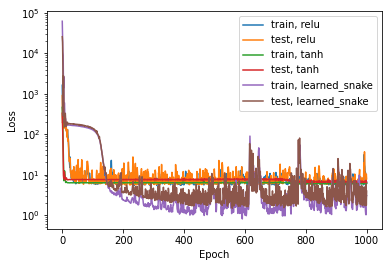

In [5]:
plt.yscale("log")
for activation in ["relu", "tanh", "learned_snake"]:
    model = SimpleMLP(ARCHITECTURE, activation)
    model, train_losses, test_losses = train_atmospheric_financial(model, train_dl, test_dl, epochs=EPOCHS, verbose=False)
    plt.plot(train_losses, label="train, "+activation)
    plt.plot(test_losses, label="test, "+activation)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

<h2> Body temperature regression

In [6]:
X_train_temp, y_train_temp, X_test_temp = get_temp_data()

In [7]:
EPOCHS = 3000
ARCHITECTURE = (1, 64, 64, 1)

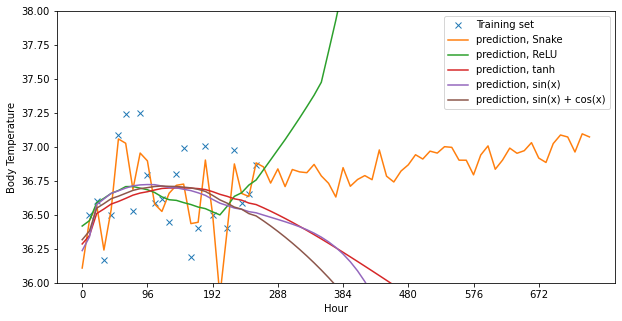

In [8]:
activations = ["snake_a=30", "relu", "tanh", "sin", "sin_plus_cos"]
labels = ["Snake", "ReLU", "tanh", "sin(x)", "sin(x) + cos(x)"]

plt.figure(figsize=(10, 5))
plt.ylim(36, 38)
plt.plot(y_train_temp, 'x', label="Training set")
for activation, label in zip(activations, labels):
    model = SimpleMLP(ARCHITECTURE, activation)
    model, train_losses = train_extrapolation(model, X_train_temp, y_train_temp, epochs=EPOCHS, verbose=False)
    with torch.no_grad():
        model.cpu()
        preds_train = model(X_train_temp)
        preds_test = model(X_test_temp)
    
    plt.plot(torch.vstack((preds_train, preds_test)), label="prediction, " + label)
plt.xticks(range(0, 71, 9), range(0, 700, 96))
plt.xlabel("Hour")
plt.ylabel("Body Temperature")
plt.legend()

<h2> Financial data regression

In [9]:
(X_train, y_train), (X_test, y_test) = preprocess_financial_data("data/IndexHistory_19950101.csv")

C:\Users\mayur\Downloads\Reproducibility Challenge\Reproducibility Challenge\data\financial_data.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(file_path, header=1, dtype={'Index Dates': int, 'Index Values': float}, skipfooter=1)


In [10]:
EPOCHS = 100
ARCHITECTURE = (1, 64, 64, 1)

Results after 10 epochs


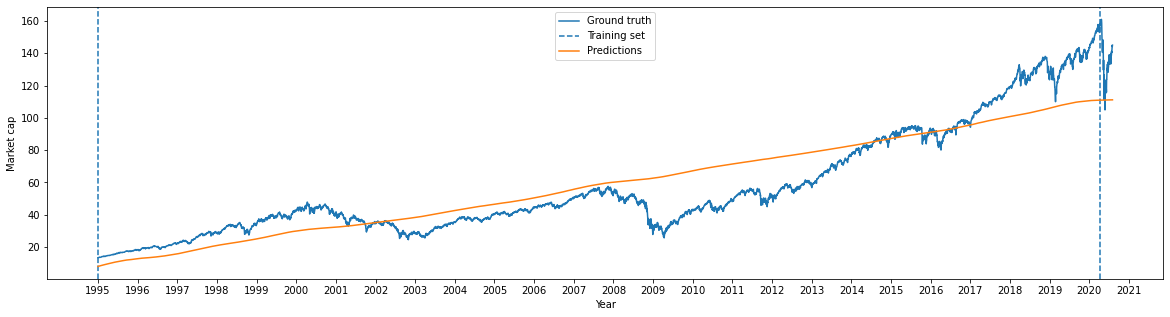

Results after 20 epochs


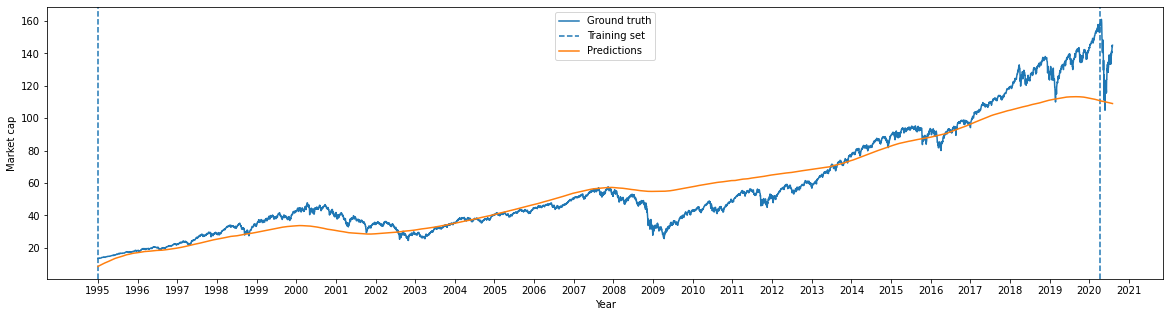

Results after 30 epochs


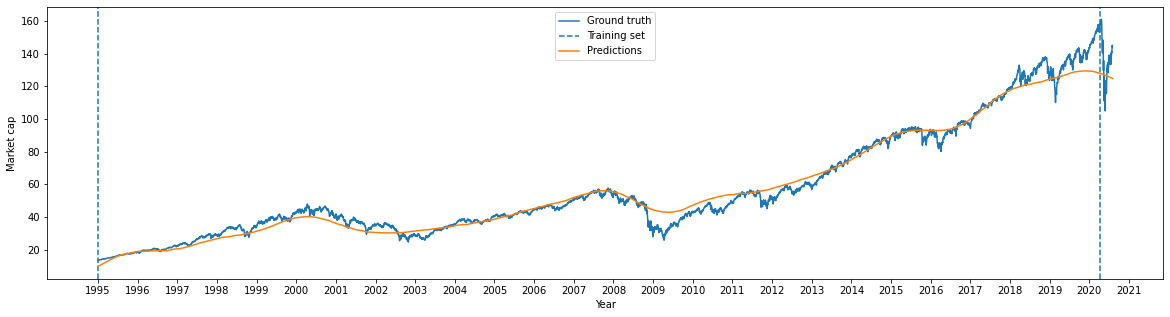

Results after 40 epochs


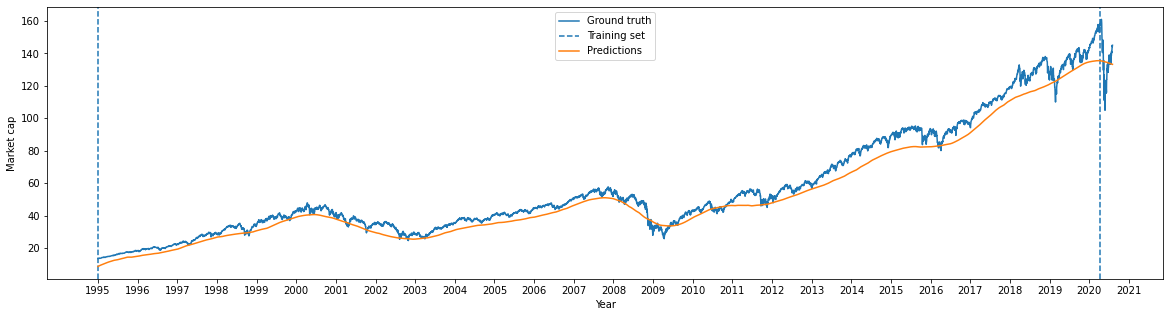

Results after 50 epochs


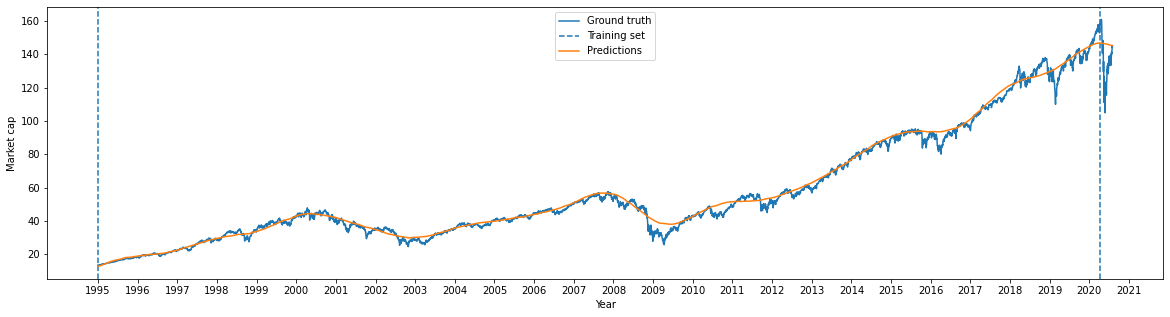

Results after 60 epochs


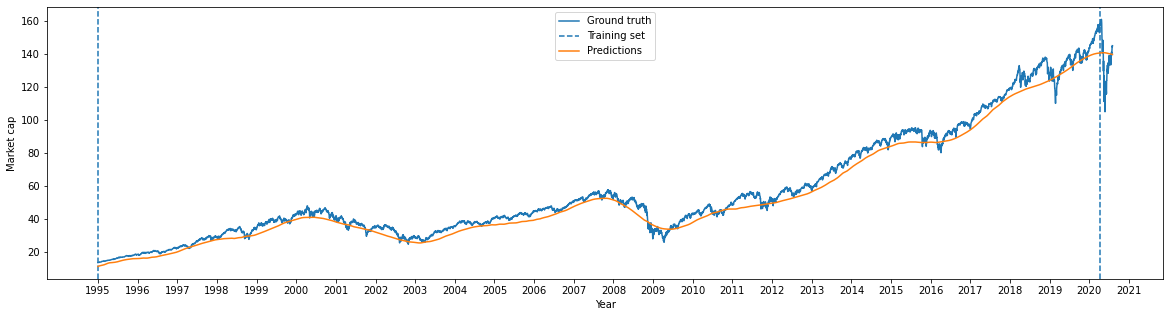

Results after 70 epochs


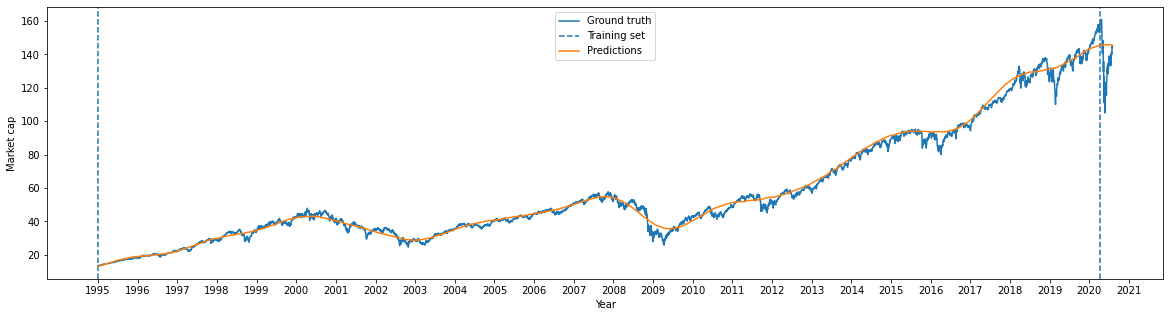

Results after 80 epochs


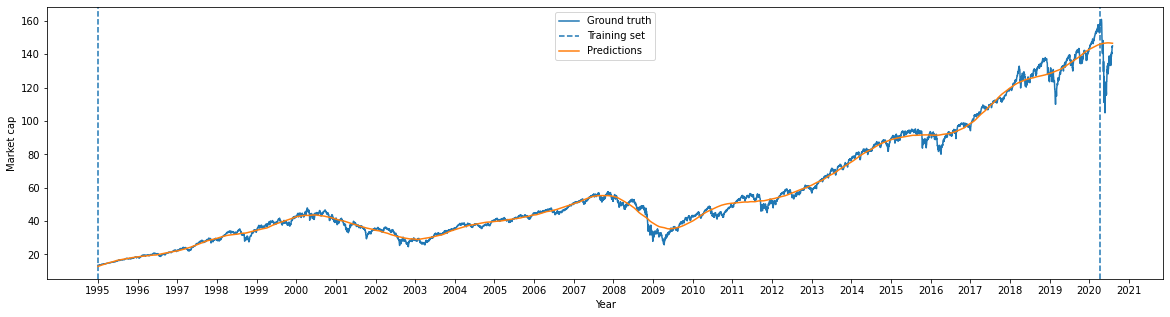

Results after 90 epochs


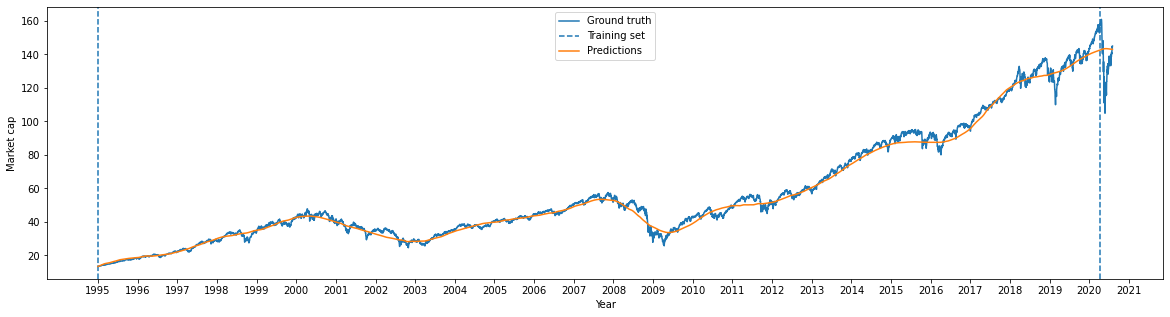

Results after 100 epochs


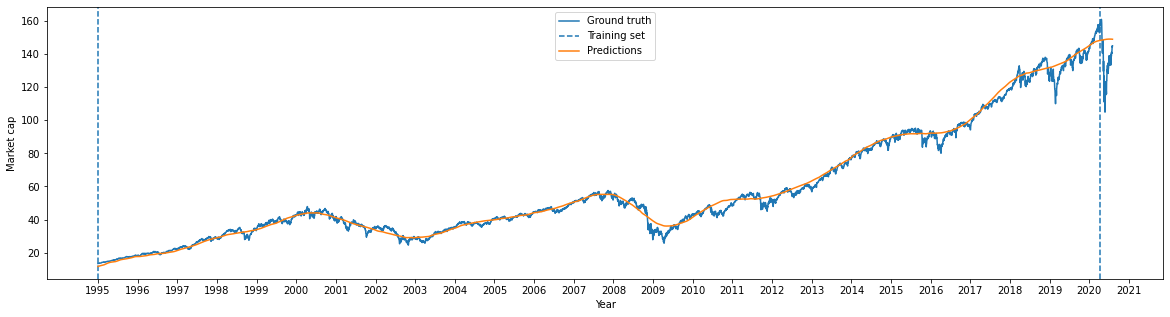

In [11]:
model = SimpleMLP(ARCHITECTURE, "snake_a=30")
train_dl, test_dl = financial_dataloaders(X_train, y_train, X_test, y_test)

#display predictions every 10 epochs
for epoch in range(0, EPOCHS, 10):
    model, train_losses, test_losses = train_atmospheric_financial(model, train_dl, test_dl, epochs=10, verbose=False)
    with torch.no_grad():
        model.cpu()
        preds_train = model(X_train)
        preds_test = model(X_test)

    print(f"Results after {epoch+10} epochs")
    plt.figure(figsize=(20, 5))
    plt.xlabel("Year")
    plt.ylabel("Market cap")
    plt.plot(torch.vstack((y_train, y_test)), label="Ground truth")
    plt.axvline(x=0, linestyle='--')
    plt.axvline(x=6315, linestyle='--', label="Training set")
    plt.plot(torch.vstack((preds_train, preds_test)), label="Predictions")
    plt.xticks(range(0, 6700, 250), range(1995, 2022))
    plt.legend()
    plt.show()

<h2>Snake MLP vs ReLU RNN

<h4> Calculating generalization loss at different sigma

Regressing sin(x/10) with sigma 0.0
Regressing sin(x/10) with sigma 0.10000000149011612
Regressing sin(x/10) with sigma 0.20000000298023224
Regressing sin(x/10) with sigma 0.30000001192092896
Regressing sin(x/10) with sigma 0.4000000059604645
Regressing sin(x/10) with sigma 0.5
Regressing sin(x/10) with sigma 0.6000000238418579
Regressing sin(x/10) with sigma 0.699999988079071
Regressing sin(x/10) with sigma 0.800000011920929
Regressing sin(x/10) with sigma 0.8999999761581421
Regressing sin(x/10) with sigma 1.0


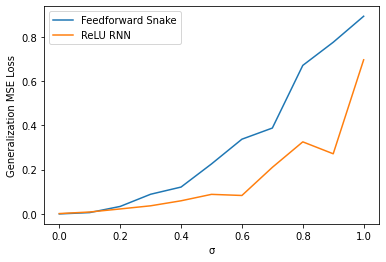

In [3]:
sigma_loss_dict_snake = {}
sigma_loss_dict_rnn = {}

for sigma in torch.arange(0, 1.1, 0.1):
    
    print(f"Regressing sin(x/10) with sigma {sigma}")
    
    X, y, y_plus_eps = sin_with_noise(sigma=sigma)
    
    train_inputs = X[:200]
    train_outputs = y_plus_eps

    test_inputs = X[200:]
    test_outputs = y[200:]
    
    model_snake = SimpleMLP((1, 64, 64, 1), "snake_a=30")
    model_rnn = RNN()

    
    train_inputs = train_inputs.reshape(-1, 1).float()/200
    train_outputs = train_outputs.reshape(-1, 1)

    train_seqs = create_inout_sequences(y_plus_eps)
    test_seqs = create_inout_sequences(y[200:])
    
    test_inputs = test_inputs.reshape(-1, 1).float()/200
    test_outputs = test_outputs.reshape(-1, 1)
    
    model_snake, train_losses_snake, test_losses_snake = train_mlp_sin_noise(model_snake, train_inputs, train_outputs, test_inputs, test_outputs, epochs=1000, verbose=False)
    sigma_loss_dict_snake[sigma.item()] = test_losses_snake[-1]
    
    model_rnn, train_losses_rnn, test_losses_rnn = train_rnn_sin_noise(model_rnn, train_seqs, test_seqs, epochs=100)
    sigma_loss_dict_rnn[sigma.item()] = test_losses_rnn[-1]

plt.xlabel("\u03C3")
plt.ylabel("Generalization MSE Loss")
plt.plot(*zip(*sorted(sigma_loss_dict_snake.items())), label="Feedforward Snake")
plt.plot(*zip(*sorted(sigma_loss_dict_rnn.items())), label="ReLU RNN")
plt.legend()
plt.show()

<h4> Compare results of snake MLP and ReLU RNN at sigma = 0.5

In [4]:
X, y, y_plus_eps = sin_with_noise(sigma=0.5)
    
train_inputs_sigma_0_5 = X[:200]
train_outputs_sigma_0_5 = y_plus_eps

test_inputs_sigma_0_5 = X[200:]
test_outputs_sigma_0_5 = y[200:]

model_snake_sigma_0_5 = SimpleMLP((1, 64, 64, 1), "snake_a=30")
model_rnn_sigma_0_5 = RNN()


train_inputs_sigma_0_5 = train_inputs_sigma_0_5.reshape(-1, 1).float()/200
train_outputs_sigma_0_5 = train_outputs_sigma_0_5.reshape(-1, 1)

train_seqs_sigma_0_5 = create_inout_sequences(y_plus_eps)
test_seqs_sigma_0_5 = create_inout_sequences(y[200:])

test_inputs_sigma_0_5 = test_inputs_sigma_0_5.reshape(-1, 1).float()/200
test_outputs_sigma_0_5 = test_outputs_sigma_0_5.reshape(-1, 1)

model_snake_sigma_0_5, _, _ = train_mlp_sin_noise(model_snake_sigma_0_5, train_inputs_sigma_0_5, train_outputs_sigma_0_5, test_inputs_sigma_0_5, test_outputs_sigma_0_5, epochs=1000, verbose=False)
model_rnn_sigma_0_5, _, _ = train_rnn_sin_noise(model_rnn_sigma_0_5, train_seqs_sigma_0_5, test_seqs_sigma_0_5, epochs=100)



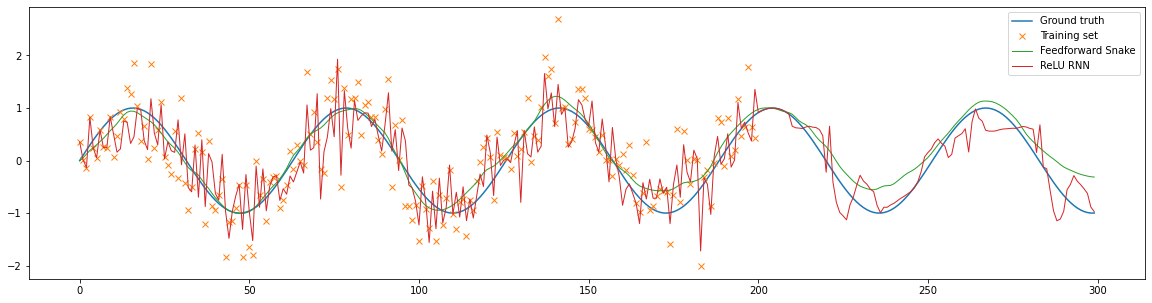

In [6]:
with torch.no_grad():
    model_snake_sigma_0_5.cpu()
    if torch.cuda.is_available():
        model_rnn_sigma_0_5.cuda()
    
    preds_train_snake_sigma_0_5 = model_snake_sigma_0_5(train_inputs_sigma_0_5)
    preds_test_snake_sigma_0_5 = model_snake_sigma_0_5(test_inputs_sigma_0_5)

    preds_train_rnn_sigma_0_5 = y_plus_eps[0:10].tolist()
    for seq, _ in train_seqs_sigma_0_5:
        if torch.cuda.is_available():
            seq = seq.cuda()
        model_rnn_sigma_0_5.hidden = torch.zeros(1, 1, model_rnn_sigma_0_5.hidden_layer_size)
        preds_train_rnn_sigma_0_5.append(model_rnn_sigma_0_5(seq).item())
       
    preds_test_rnn_sigma_0_5 = y[200:210].tolist()
    for seq, _ in test_seqs_sigma_0_5:
        if torch.cuda.is_available():
            seq = seq.cuda()
        model_rnn_sigma_0_5.hidden = torch.zeros(1, 1, model_rnn_sigma_0_5.hidden_layer_size)
        preds_test_rnn_sigma_0_5.append(model_rnn_sigma_0_5(seq).item())
    
plt.figure(figsize=(20, 5))
plt.plot(X, y, label="Ground truth")
plt.plot(X[:200], y_plus_eps, 'x', label='Training set')
plt.plot(X, torch.vstack((preds_train_snake_sigma_0_5,  preds_test_snake_sigma_0_5)), linewidth=1, label="Feedforward Snake")
plt.plot(preds_train_rnn_sigma_0_5+preds_test_rnn_sigma_0_5, linewidth=1, label="ReLU RNN")
plt.legend()
plt.show()

<h4> Compare time taken for 1 epoch of MLP vs RNN

In [7]:
a, b = torch.Tensor([1, 2, 5]), torch.Tensor([2, 3, 4])
T = torch.hstack([a * 10.**x for x in b])

In [8]:
feedforward_time_dict = {}
rnn_time_dict = {}

for t in T:
    print(f"Calculating time taken for a single epoch with {t} timesteps")
    X, y, y_plus_eps = sin_with_noise(low_bound=0, up_bound=t, train_split=math.ceil(t*0.66), sigma=0.5)

    train_inputs = X[:math.ceil(t*0.66)]
    train_outputs = y_plus_eps

    test_inputs = X[math.ceil(t*0.66):]
    test_outputs = y[math.ceil(t*0.66):]

    model_snake = SimpleMLP((1, 64, 64, 1), "snake_a=30")
    model_rnn = RNN()


    train_inputs = train_inputs.reshape(-1, 1).float()/(math.ceil(t*0.66))
    train_outputs = train_outputs.reshape(-1, 1)

    train_seqs = create_inout_sequences(y_plus_eps)
    test_seqs = create_inout_sequences(y[math.ceil(t*0.66):])

    test_inputs = test_inputs.reshape(-1, 1).float()/(math.ceil(t*0.66))
    test_outputs = test_outputs.reshape(-1, 1)

    tic = time.time()
    _, _, _ = train_mlp_sin_noise(model_snake, train_inputs, train_outputs, test_inputs, test_outputs, 1, verbose=False)
    toc = time.time()
    
    feedforward_time_dict[t] = toc-tic
    
    tic = time.time()
    _, _, _ = train_rnn_sin_noise(model_rnn, train_seqs, test_seqs, 1)
    toc = time.time()
    
    rnn_time_dict[t] = toc-tic
    
    

Calculating time taken for a single epoch with 100.0 timesteps
Calculating time taken for a single epoch with 200.0 timesteps
Calculating time taken for a single epoch with 500.0 timesteps
Calculating time taken for a single epoch with 1000.0 timesteps
Calculating time taken for a single epoch with 2000.0 timesteps
Calculating time taken for a single epoch with 5000.0 timesteps
Calculating time taken for a single epoch with 10000.0 timesteps
Calculating time taken for a single epoch with 20000.0 timesteps
Calculating time taken for a single epoch with 50000.0 timesteps


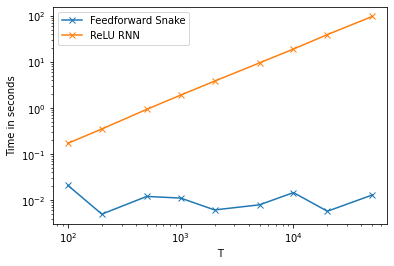

In [9]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("T")
plt.ylabel("Time in seconds")
plt.plot(*zip(*sorted(feedforward_time_dict.items())), 'x-', label="Feedforward Snake")
plt.plot(*zip(*sorted(rnn_time_dict.items())), 'x-', label="ReLU RNN")
plt.legend()